**Problem Set #2**

Computational Astrodynamics (ΥΦΥ204)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**


# Exercise 2.1

## Problem statement

Assume an artificial satellite identical to the International Space Station (ISS) ($m=400 kg$, $S=8000 m^{2}$), in a circular low earth orbit ($h=400 km$). Assume a planar motion in Oxy, a geocentric reference frame and the initial conditions which are given in the figure below:

![](set2_initial_conditions.png "Initial conditions for the exercise")

Write a numerical integration program for the satellite's equations of motion in cartesian coordinates, assuming only the gravitational pull of the Earth and using the initial conditions from the figure. Validate the stability of the orbit by measuring the error for the satellite's height for a propagation time equal to 6000 orbits of the satellite.

## Solution 

Let us first determine the initial conditions based on the figure. Assuming the earth radius to be $R_{Earth}=6371 km$:

$$
a = R_{Earth}+h = 6371 + 400 = 6771 km
$$

Since we have a circular orbit constrained in the XY reference plane, it follows that $e=0$, $i=0$ and $\Omega = 0$. Finally, we can assume an initial value for the argument of pericenter of $\omega = 90^{\circ}$ and an initial mean anomaly value $M=0$, leading to the desired initial position of the spacecraft as defined by the figure above. The initial orbital elements can be found below:

|         Orbital Element         |     Value     |
|:-------------------------------:|:-------------:|
|         Semi-major axis         |  6771000 m|
|           Eccentricity          | $0$    |
|           Inclination           | $0^{\circ}$  |
| Longitude of the ascending node | $0^{\circ}$ |
|      Argument of pericenter     | $90^{\circ}$ |
|           Mean anomaly          | $0^{\circ}$ |

Since no forces are acting on the spacecraft besides the gravitational force, the equation of motion can be described by the following equation:

$$
\begin{split}
\ddot{\overrightarrow{r}}&+\frac{\mu}{r^{2}} \frac{\overrightarrow{r}}{r}=0 \\
\ddot{\overrightarrow{r}}&=-\frac{\mu \overrightarrow{r}}{r^{3}}
\end{split}
$$

This equation can be replaced by 2 first order equations for each cartesian coordinate. For clarity, we will also include the z-dimension. The equation can thus be replaced by the following equations:

$$
\begin{split}
\dot{x}&=v_{x} \\
\dot{y}&=v_{y} \\
\dot{z}&=v_{z} \\
v_{x}&=\frac{-\mu x}{\sqrt{x^{2}+y^{2}+z^{2}}} \\
v_{y}&=\frac{-\mu y}{\sqrt{x^{2}+y^{2}+z^{2}}} \\
v_{z}&=\frac{-\mu z}{\sqrt{x^{2}+y^{2}+z^{2}}}
\end{split}
$$

The code implemented can be found below. First, we will use the previously developed transformation from orbital elements to cartesian to compute the initial values for the velocity and position vectors. We will then treat the 6 equations which we derived above as a system of differential equations and we will solve them using a fourth order Runge-Kutta integrator. We will plot a single orbit for visualization purposes and we will then validate our code, by integrating for a total of 6000 orbits for different time steps and we will log the percent error between the initial and the final radius (equivalent to height) values. We will also log the time it took for the computer to perform each integration and discuss the results.

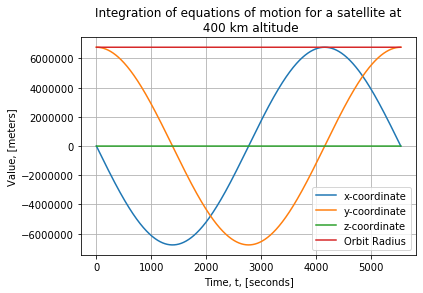

Propagator Validation for 33255681.31219161 seconds
Time step (sec)		% Error		Run time (sec)
60			0.15354		44.54
50			0.06147		45.82
40			0.02010		56.46
30			0.00477		88.10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector

    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    elif M > np.pi:
        E_0 = M + e
    else:
        E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E: M - E + np.sin(E)
    fdot = lambda E: -1 + np.cos(E)
    # Stopping criteria
    N = 15  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev) / fdot(E_prev))
        ea = np.fabs((E_next - E_prev) * 100 / E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            # print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu / pow(a, 3))  # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega), -np.sin(omega), 0],
                   [np.sin(omega), np.cos(omega), 0],
                   [0, 0, 1]])
    P2 = np.array([[1, 0, 0],
                   [0, np.cos(i), np.sin(i)],
                   [0, np.sin(i), np.cos(i)]])
    P3 = np.array([[np.cos(Omega), -np.sin(Omega), 0],
                   [np.sin(Omega), np.cos(Omega), 0],
                   [0, 0, 1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x, y, 0])
    x_y_dot_vector = np.array([x_dot, y_dot, 0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_dot_vector)
    return r_vector, v_vector


def runge_kutta_4(x_0, y_0, z_0, vx_0, vy_0, vz_0, mu, t_start, tmax, h):
    # 4th order Runge Kutta orbit propagator
    # Input:
    # x_0, y_0, z_0, namely the coordinates of the position vector [meters]
    # vx_0, vy_0, vz_0, namely the coordinates of the velocity vector [m/s]
    # mu, mu constant
    # t_start, initial time [seconds]
    # t_end, propagation end time [seconds]
    # h, integration step size [seconds]
    # Output is 7 vectors containing position, velocity and time information at each integration step

    # Log initial values
    tn = [t_start]
    xn = [x_0]
    yn = [y_0]
    zn = [z_0]
    vxn = [vx_0]
    vyn = [vy_0]
    vzn = [vz_0]
    counter = 0
    # Main RK4 loop
    while tn[counter] < tmax:
        # Calculate k1 values
        k1_x = fx(vx_0)
        k1_y = fy(vy_0)
        k1_z = fz(vz_0)
        k1_vx = fv_x(x_0, y_0, z_0, mu)
        k1_vy = fv_y(x_0, y_0, z_0, mu)
        k1_vz = fv_z(x_0, y_0, z_0, mu)
        # Calculate midpoint values
        mid_x = x_0 + k1_x * h/2
        mid_y = y_0 + k1_y * h/2
        mid_z = z_0 + k1_z * h/2
        mid_vx = vx_0 + k1_vx * h/2
        mid_vy = vy_0 + k1_vy * h/2
        mid_vz = vz_0 + k1_vz * h/2
        # Calculate k2 values
        k2_x = fx(mid_vx)
        k2_y = fy(mid_vy)
        k2_z = fz(mid_vz)
        k2_vx = fv_x(mid_x, mid_y, mid_z, mu)
        k2_vy = fv_y(mid_x, mid_y, mid_z, mu)
        k2_vz = fv_z(mid_x, mid_y, mid_z, mu)
        # Calculate next midpoint values
        mid_x = x_0 + k2_x * h / 2
        mid_y = y_0 + k2_y * h / 2
        mid_z = z_0 + k2_z * h / 2
        mid_vx = vx_0 + k2_vx * h / 2
        mid_vy = vy_0 + k2_vy * h / 2
        mid_vz = vz_0 + k2_vz * h / 2
        # Calculate k3 values
        k3_x = fx(mid_vx)
        k3_y = fy(mid_vy)
        k3_z = fz(mid_vz)
        k3_vx = fv_x(mid_x, mid_y, mid_z, mu)
        k3_vy = fv_y(mid_x, mid_y, mid_z, mu)
        k3_vz = fv_z(mid_x, mid_y, mid_z, mu)
        # Calculate next midpoint values
        mid_x = x_0 + k3_x * h
        mid_y = y_0 + k3_y * h
        mid_z = z_0 + k3_z * h
        mid_vx = vx_0 + k3_vx * h
        mid_vy = vy_0 + k3_vy * h
        mid_vz = vz_0 + k3_vz * h
        # Calculate k4 values
        k4_x = fx(mid_vx)
        k4_y = fy(mid_vy)
        k4_z = fz(mid_vz)
        k4_vx = fv_x(mid_x, mid_y, mid_z, mu)
        k4_vy = fv_y(mid_x, mid_y, mid_z, mu)
        k4_vz = fv_z(mid_x, mid_y, mid_z, mu)
        # Compute r, v values and append to list
        xn.append(xn[counter] + (h / 6) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x))
        yn.append(yn[counter] + (h / 6) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y))
        zn.append(zn[counter] + (h / 6) * (k1_z + 2 * k2_z + 2 * k3_z + k4_z))
        vxn.append(vxn[counter] + (h / 6) * (k1_vx + 2 * k2_vx + 2 * k3_vx + k4_vx))
        vyn.append(vyn[counter] + (h / 6) * (k1_vy + 2 * k2_vy + 2 * k3_vy + k4_vy))
        vzn.append(vzn[counter] + (h / 6) * (k1_vz + 2 * k2_vz + 2 * k3_vz + k4_vz))
        # Prepare for the next iteration and reset values
        counter += 1
        tn.append(tn[counter - 1] + h)
        x_0 = xn[counter]
        y_0 = yn[counter]
        z_0 = zn[counter]
        vx_0 = vxn[counter]
        vy_0 = vyn[counter]
        vz_0 = vzn[counter]
    return xn, yn, zn, vxn, vyn, vzn, tn


def fx(v_x):
    # Assuming x'(t)=v_x
    return v_x


def fy(v_y):
    # Assuming y'(t)=v_y
    return v_y


def fz(v_z):
    # Assuming z'(t)=v_z
    return v_z


def fv_x(x, y, z, mu):
    # Assuming v_x'(t)=-mu*x/(sqrt(x^2+y^2+z^2))^3
    return -mu*x/pow(np.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)), 3)


def fv_y(x, y, z, mu):
    # Assuming v_y'(t)=-mu*y/(sqrt(x^2+y^2+z^2))^3
    return -mu*y/pow(np.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)), 3)


def fv_z(x, y, z, mu):
    # Assuming v_z'(t)=-mu*z/(sqrt(x^2+y^2+z^2))^3
    return -mu*z/pow(np.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)), 3)


# Constants definition
G = 6.6743*pow(10, -11)
M_earth = 5.977*pow(10, 24)
mu_earth = G*M_earth
R_earth = 6371000  # [meters]

# Orbit definition
H = 400000  # Altitude, [meters]
a = R_earth + H  # Semi-major axis, [meters]
i = 0  # Inclination, [deg]
e = 0  # Eccentricity, []
Omega = 0  # Longitude of the Ascending Note [deg]
omega = 90  # Argument of pericenter [deg]
M = 0  # Mean anomaly, [deg]
T = 2 * np.pi * np.sqrt(pow(a, 3)/mu_earth)  # Orbital period, [seconds]

# Compute initial position and velocity vector from orbital elements
r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu_earth)
x = r_vector[0]
y = r_vector[1]
z = r_vector[2]
vx = v_vector[0]
vy = v_vector[1]
vz = v_vector[2]

# Propagate orbit (all times in seconds)
start_time = 0
end_time = T
time_step = 1
xn, yn, zn, vxn, vyn, vzn, tn = runge_kutta_4(x, y, z, vx, vy, vz, mu_earth, start_time, end_time, time_step)

# Compute r magnitude
r = np.zeros(np.size(xn))
for i in range(0, np.size(xn)):
    r[i] = np.sqrt(pow(xn[i], 2) + pow(yn[i], 2) + pow(zn[i], 2))

# Plot results for one orbit
plt.plot(tn, xn, label='x-coordinate')
plt.plot(tn, yn, label='y-coordinate')
plt.plot(tn, zn, label='z-coordinate')
plt.plot(tn, r,  label='Orbit Radius')
plt.xlabel('Time, t, [seconds]')
plt.ylabel('Value, [meters]')
plt.title('Integration of equations of motion for a satellite at\n 400 km altitude')
plt.grid()
plt.legend()
plt.show()

# Validate propagator by computing error for different step sizes for 6000 orbits
start_time = 0
end_time = 6000*T
time_steps = np.array([60, 50, 40, 30, 20])
print('=======================================================')
print('Propagator Validation for ' + str(end_time) + ' seconds')
print('=======================================================')
print('Time step (sec)\t\t% Error\t\tRun time (sec)')
for counter in range(0, np.size(time_steps)):
    timer_start = time.time()
    xn, yn, zn, vxn, vyn, vzn, tn = \
        runge_kutta_4(x, y, z, vx, vy, vz, mu_earth, start_time, end_time, time_steps[counter])
    # Compute r magnitude
    r = np.zeros(np.size(xn))
    for i in range(0, np.size(xn)):
        r[i] = np.sqrt(pow(xn[i], 2) + pow(yn[i], 2) + pow(zn[i], 2))
    # Compute error
    r_initial = r[0]
    r_final = r[np.size(xn)-1]
    error = np.fabs(r_final-r_initial)/r_initial*100
    time_taken = time.time() - timer_start
    print('%d\t\t\t%.5f\t\t%.2f' % (time_steps[counter], error, time_taken))


## Discussion

From the generated figure we can verify that we used the correct initial conditions (max y-value since the spacecraft for $t=0$ is on the positive side of the Oy axis. We also note that for one orbit the radius of the orbit remains constant, leading us to the conclusion that the propagator works as intended. To validate the propagator, we propagated the orbit for a total of 6000 orbits using different time steps, which can also be seen in the table below:

| Time step [sec] | Error [%] | Run time [sec] |
|:---------------:|:---------:|:--------------:|
|        60       |  0.15354  |      36.44     |
|        50       |  0.06147  |      44.31     |
|        40       |  0.02010  |      55.11     |
|        30       |  0.00477  |      73.26     |
|        20       |  0.00063  |     110.85     |

We can observe that even if we use a time step of 60 seconds, the percentage error remains under 1% and the run time remains sufficiently small. Decreasing the time step further improves the error on the height/radius, but the run time starts to rise to unacceptably long times. Nevertheless, we have demonstrated that the integrator implemented using the fourth order Runge-Kutta method works as intended. 

# Exercise 2.2

## Problem statement

For the problem of exercise 2.1, include aerodynamic drag due to the atmosphere of the Earth. For simplicity, assume that the density is given by the function $\rho=(0.1H)^{-7.5} \frac{kg}{m^{3}}$ for $H>15 km$ and $\rho=0.1 \frac{kg}{m^{3}}$ for $H<15 km$. The spacecraft properties can be seen in the figure above. Find the time taken until the spacecraft reaches the surface of the Earth. Compare this result with a prediction made using Gauss' equation (for $e=0$, assuming the same densit